# 2D Multigrid for Dary Flow <div style="text-align: right"> **[Total : 34 points]** </div>

In the exercises, we have explored some steps towards multigrid, mostly for the Poisson equation and simple discretizations.
Furthermore, we have only discussed one-dimensional problems.
The problem is, of course, that both one-dimensional problems and the Poisson equation are relatively tame from a numerical perspective. You don't see the advantages of multigrid nn these scenarios,

In this worksheet, we are going to look at the Darcy flow equation, discretized with a simple finite elements scheme on a hierarchical quad-tree based grid.
All concepts are exactly the same as you've seen in the course, but applied in a more difficult setting.

In [1]:
%matplotlib inline
import numpy as np


import scipy.special as special
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import patches

import sys
sys.path.append("../src/")

import quadtree
import plotter
import fem

C:\Users\lims\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## The PDE: Darcy Flow
We are solving the steady state Darcy flow equation.
This equation states the law of fluid flow through a porous medium, e.g. through sand.

We have the steady-state fluid pressure $u$ and the spatially varying permeability $K(x,y)$.
The PDE is basically a variable-coefficient version of the Poission equation and looks like:
$$- \nabla \cdot \left(K(x,y) \nabla u \right) = f,
\qquad \forall \mathbf{x} \in \Omega
$$
with boundary conditions
\begin{align}
u(x,y) &= 0 \qquad \forall x \in \Gamma_D \\
-K(x) \nabla u \cdot n &= 0 \qquad \forall x \in \Gamma - \Gamma_D
\end{align}
where $\Gamma$ is the boundary and $\Gamma_D$ is the Dirichlet part of the boundary.

The Dirichlet boundary is on the top of the domain, all other boundary conditions are set to Neumann.

After multiplying by a testfunction $\phi(x,y)$ and integrating over the domain, we get the weak form:
$$\int_\Omega \nabla \phi(x,y) \cdot  (K(x,y) \nabla u(x,y) \mathrm{d}\Omega = \int_\Omega \phi(x,y) f(x,y) \mathrm{d}\Omega$$
The boundary terms are zero due to the choice of boundary conditions.
In our case we use a constant right-hand side of $f(x,y) = 1$.


# The grid
We define a quadtree-based grid, as this allows us to perform hierarchical algorithms with ease.
Briefly, we decompose the domain into squares.

# Discretization
For the discretization we use a simple linear continuous finite elements approach.

We choose a nodal linear Lagrange basis, with points $x_1 = -1, x_2 = 1$.
This was discussed in the lecture as a piecewise-linear hat basis.
The 1D-basis functions are then
\begin{align}
l_1(x) &= -\frac{x-1}{2} \\
l_2(x) &= +\frac{x+1}{2} \\
\end{align}
We combine them by 
$$L(x) = a_1 l_1(x) + a_2 l_2(x)$$
where $a_1, a_2$ are coefficients.
In 2D, we have the points $(-1,-1), (-1, 1), (1, -1), (1,1)$ and the solution is expressed as
$$u(x,y) \approx a_1 l_1(x) l_2(y) + a_2 l_1(x) l_2(y) + a_3 l_1(x) l_2(y) + a_4 l_1(x) l_2(y) $$

Note that each vertex has a coefficient (the value of $u(x,y)$ at that point) and a corresponding basis function.
We use this basis to represent both the test functions $\phi(x,y)$ and the discrete solution $u(x,y)$.

Furthermore, be careful that all basis functions are defined on the reference cell $[-1,1]^2$ but all grid coordinates are defined in terms of global coordinates.

Finally, we end up with a stiffness matrix $A_{ij}$ and a right-hand side $f_{i}$, where $i$ and $j$ are indices of vertices.
It is important to note here that we remove rows and columns where either $i$ or $j$ corresponds to a vertex where the Dirichlet boundary condition is enfored.
We do this to ensure that the remaining system is symmetric.

This is all you need to know about the discretization to finish this notebook.
If you are interested, you can find details in the file *fem.py*. This might also supply you with hints about details regarding the grid, basis, etc.

In [2]:
# Here we build up the geometry.
# The code is included in the notebook because it makes it easier to see
# how the vertices get numbered.
class Geometry:
    def __init__(self, level):
        center = np.array([0.5, 0.5])
        size = 1.0
        self.grid = quadtree.Quadtree(center=center, size=size)
        self.grid.split_to_level(level)
       
        self.vertices_coords_to_idx, \
        self.number_of_vertices_per_level, \
        self.boundary_vertices = self.grid.get_vertices()
        self.vertices_idx_to_coords = {v: k for k, v in self.vertices_coords_to_idx.items()}
        self.grid.set_all_cell_vertices(self.vertices_coords_to_idx)
        self.grid.set_all_cell_indices()
        
        self.dirichlet_vertices = set()
        for v in self.boundary_vertices:
            eps = 1e-8
            if self.vertices_idx_to_coords[v][1] >= (1 - eps):
                self.dirichlet_vertices.add(v)
        
        dirichlet_vertices_array = np.array([*self.dirichlet_vertices])
        # We do not store the data for Dirichlet values
   
        self.data_size_per_level = []
        for level in range(self.grid.get_max_level()+1):
            n_vert = self.number_of_vertices_per_level[level]
            n_dirichlet_vert = len(
                dirichlet_vertices_array[
                    dirichlet_vertices_array < n_vert])
            self.data_size_per_level.append(n_vert - n_dirichlet_vert)
            
        
        self.vertex_idx_to_data_idx = np.zeros(self.number_of_vertices_per_level[-1], dtype=np.int32)
        self.data_idx_to_vertex_idx = np.zeros(self.data_size_per_level[-1], dtype=np.int32)
        cur_data_idx = 0
        for i in range(self.number_of_vertices_per_level[-1]):
            if i in self.dirichlet_vertices:
                self.vertex_idx_to_data_idx[i] = -1
            else:
                self.vertex_idx_to_data_idx[i] = cur_data_idx
                self.data_idx_to_vertex_idx[cur_data_idx] = i
                cur_data_idx += 1       
        

geometry = Geometry(level=4)
geometry.number_of_vertices_per_level[0]

Level 0 has 	4 vertices
Level 1 has 	5 vertices
Level 2 has 	16 vertices
Level 3 has 	56 vertices
Level 4 has 	208 vertices


4

The figure below shows the grid for level 3.
The red crosses show the vertices (at which the solution is defined), the black circle shows the cell center which is connected by the line. This line shows the order of cells (they are in Z-order), starting from the top-left.

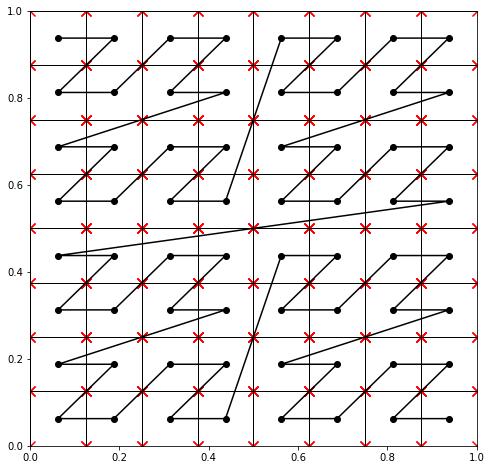

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(geometry.grid.offset[0], geometry.grid.size)
ax.set_ylim(geometry.grid.offset[1], geometry.grid.size) 
plotter.plot_grid(fig,
                  ax,
                  geometry.grid,
                  level=3,
                  c='black', 
                  vertices=geometry.vertices_idx_to_coords,
                  plot_curve=True,
                  plot_center=True,
                  plot_vertices=True)

## Solving the system for a single level
Below we show how to setup a discretization, geometry and stiffness matrix and rhs.
We also show how to compute a solution with a direct solver.

In [4]:
# Use a simple material
def eval_k(x,y):
    return x + y

level = 4
geometry = Geometry(level=4)
discretization = fem.Discretization(geometry,level=level,eval_k=eval_k)
stiffness = discretization.setup_stiffness()
rhs = discretization.setup_rhs()
sol = splinalg.spsolve(stiffness, rhs)

# System is solved correctly to double precision:
np.linalg.norm(stiffness @ sol - rhs)


Level 0 has 	4 vertices
Level 1 has 	5 vertices
Level 2 has 	16 vertices
Level 3 has 	56 vertices
Level 4 has 	208 vertices


8.340819624499995e-15

## Plotting the solution
You can visualize the solution with *plot_solution* as below.
It also kept in the notebook as a further example of a grid traversal, for the evaluation of the basis functions and for the handling of Dirichlet boundary conditions.

The left plot shows the solution, the right one shows the material parameter.
Dirichlet vertices are marked with black x.

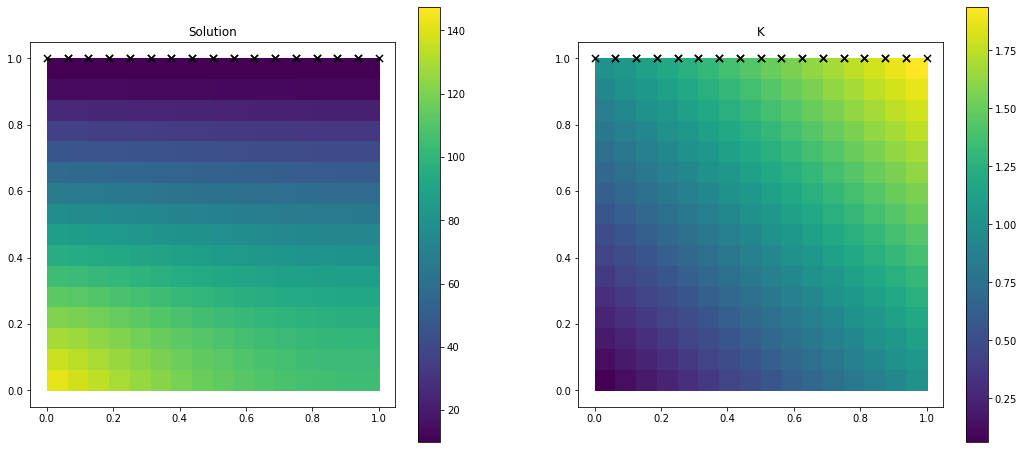

In [5]:
def plot_solution(geometry, discretization, sol):
    # First find minimum and maximum material parameter
    min_k, max_k = float('inf'), float('-inf')
    for cell in geometry.grid.dfs(only_level=level):
        k = discretization.eval_k(cell.center[0], cell.center[1])
        min_k = min(k, min_k)
        max_k = max(k, max_k)

    # Set up color scales for the solution and the material k.
    norm_solution = mpl.colors.Normalize(vmin=sol.min(), vmax=sol.max())
    norm_k = mpl.colors.Normalize(vmin=min_k, vmax=max_k)
    cmap = cm.viridis
    color_mapper_solution = cm.ScalarMappable(norm=norm_solution, cmap=cmap)
    color_mapper_k = cm.ScalarMappable(norm=norm_k, cmap=cmap)

    fig, axs = plt.subplots(1,2, figsize=(18,8))
    
    # Lists to store Dirichlet vertices.
    dirichlet_xs = []
    dirichlet_ys = []

    for cell in geometry.grid.dfs(only_level=level):
        value = 0.0
        # Evaluate all basis functions at (0.5, 0.5)
        for i, vertex in enumerate(cell.vertices):
            # Ignore dirichlet boundary conditions.
            # Their value is not stored and is always zero.
            if vertex not in geometry.dirichlet_vertices:
                # Here we get the index of the data correspond to the vertex.
                data_idx = geometry.vertex_idx_to_data_idx[vertex]
                value += sol[data_idx] * fem.lagrange_2d(discretization.nodes_x, i, (0.5,0.5))

        # Plot the rectangles that build up the grid.
        rect = patches.Rectangle(
            cell.offset,
            cell.size,
            cell.size,
            fill=True,
            color=color_mapper_solution.to_rgba(value))
        axs[0].add_patch(rect)

        # Plot material
        value = discretization.eval_k(cell.center[0], cell.center[1])
        rect = patches.Rectangle(
            cell.offset,
            cell.size,
            cell.size,
            fill=True,
            color=color_mapper_k.to_rgba(value))
        axs[1].add_patch(rect)    

        # Find dirichlet vertices
        for v in cell.vertices:
            if v in geometry.dirichlet_vertices:
                dirichlet_xs.append(geometry.vertices_idx_to_coords[v][0])
                dirichlet_ys.append(geometry.vertices_idx_to_coords[v][1])
                
    axs[0].set_title("Solution")
    axs[0].axis('square')

    axs[1].set_title("K")
    axs[1].axis('square')

    # Mark Dirichlet vertices with black x.
    for ax in axs:
        ax.scatter(dirichlet_xs, dirichlet_ys, c='black', zorder=10, marker='x', s=50)
        
    fig.colorbar(color_mapper_solution, ax=axs[0])    
    fig.colorbar(color_mapper_k, ax=axs[1])

plot_solution(geometry=geometry, discretization=discretization, sol=sol)

# Multigrid
## The interpolation and prolongation operators
As we've discussed, we are using a finite elements discretization for our equation.
An advantage of this is that we have a continuous solution over the entire domain.
This is quite helpful for definiting the interpolation operator.

Let's look at a single cell and the corresponding fine cells:

Text(0.5, 1.0, 'Corresponding Fine Cell')

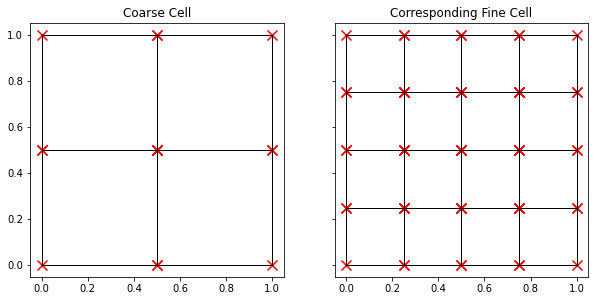

In [6]:
# Take the first and only cell of level 0.
cells = list(geometry.grid.dfs(only_level=0))
c = cells[0]

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,10))
plotter.plot_grid(fig, axs[0], grid=c, level=1, vertices=geometry.vertices_idx_to_coords, plot_vertices=True)
plotter.plot_grid(fig, axs[1], grid=c, level=2, vertices=geometry.vertices_idx_to_coords, plot_vertices=True)
axs[0].axis('square')
axs[0].set_title("Coarse Cell")
axs[1].axis('square')
axs[1].set_title("Corresponding Fine Cell")

The left cell in the figure is the coarse cell.
The red Xs mark the vertices of each cell.

On the right, you can see the corresponding four cells of the grid with one level more.
Note that all vertices in the coarse grid also exist in the fine grid.
For these vertices, it is trivial to define the fine grid solution.
The other vertices can be found by evaluating the basis functions of the coarse cell at their position.
In our case, this corresponds to (bi-)linear interpolation.

Below you can find some examples of iterating over the vertices of a cell.
You can also see how to find the global and reference coordinates for each.
Note that each vertex has a global index and a data index.
Because the unknowns for the Dirichlet vertices are not stored explicitely, both indices are not identical.
Before accessing any matrix/vector that has anything to do with the discrete solution, you need to convert the vertex idx to the data idx.

Note that both vertex and data indices are ordered s.t. all indices for a coarse grid also exist in all finer grids.

In [7]:
# Example of finding vertices:

# Take a random cell
cell = next(geometry.grid.dfs(only_level=1))
print("Found cell with center {center} and size {size}".format(
    center=cell.center, 
    size=cell.size))

# Next we find the parent of the cell
parent = cell.parent
print("Its parent has center {center} and size {size}".format(
    center=parent.center, 
    size=parent.size))

# Our cell has a few vertices:
for i, vertex in enumerate(cell.vertices):
    global_coords = geometry.vertices_idx_to_coords[vertex]
    reference_coords = fem.map_to_reference_coordinates(cell, global_coords)
    print(
        "child's  \t{i}th vertex has index {idx}, data index {data_idx}, global coordinates {global_coords} and reference coordinates {reference_coords}".format(
    i=i,
    idx=vertex,
    data_idx=geometry.vertex_idx_to_data_idx[vertex],
    global_coords=global_coords,
    reference_coords=reference_coords))
    
print()
# The parent also has vertices:
for i, vertex in enumerate(parent.vertices):
    global_coords = geometry.vertices_idx_to_coords[vertex]
    reference_coords = fem.map_to_reference_coordinates(parent, global_coords)
    print(
        "parent's\t{i}th vertex has index {idx}, data index {data_idx},  global coordinates {global_coords} and reference coordinates {reference_coords}".format(
    i=i,
    idx=vertex,
    data_idx=geometry.vertex_idx_to_data_idx[vertex],
    global_coords=global_coords,
    reference_coords=reference_coords))
# Note that the vertices of both cells have the same reference coordinates.     

        
# Now we want to evaluate the 
# We can take the first vertex of the PARENT
first_basis_function_parent = parent.vertices[0]
first_vertex_cell = cell.vertices[0]
coordinates_vertex_cell = np.array(geometry.vertices_idx_to_coords[first_vertex_cell])
# Important: We map to the reference coordinates of the PARENT!
reference_coordinates_vertex_cell = fem.map_to_reference_coordinates(parent, coordinates_vertex_cell)

# and evaluate the basis function of the parent
# Note here that the basis is 
print("\nEvaluated first basis function of the parent at position of first reference cell: {}".format(
    fem.lagrange_2d(discretization.nodes_x, first_basis_function_parent, reference_coordinates_vertex_cell)))

# We can also do this with the second basis function and vertex.
# Note that these two have the same coordinates.
# We thus expect the basis function to evaluate to one.
basis_parent = parent.vertices[1]
coords_vertex_cell = fem.map_to_reference_coordinates(parent, 
                                                      np.array(geometry.vertices_idx_to_coords[cell.vertices[1]]))
print("Evaluated second basis function of the parent at position of second reference cell: {}".format(
    fem.lagrange_2d(discretization.nodes_x, basis_parent, coords_vertex_cell)))

# Show that vertices of level l are subset of vertices of level l+1
def collect_vertex_ids(geometry, level):
    vertex_ids = set()
    data_ids = set()
    # You can iterate through the cells of a level with a depth-first search.
    for cell in geometry.grid.dfs(only_level=level):
        for vertex in cell.vertices:
            vertex_ids.add(vertex)
            if vertex not in geometry.dirichlet_vertices:
                data_ids.add(geometry.vertex_idx_to_data_idx[vertex])
            
    return vertex_ids, data_ids

v_0, d_0 = collect_vertex_ids(geometry, 0)
v_1, d_1 = collect_vertex_ids(geometry, 1)
print("Vertices of level 0 are\t\t{},\nvertices of level 1 are\t\t{}".format(v_0, v_1))
print("Data indices of level 0 are\t{},\ndata indices of level 1 are\t{}".format(d_0, d_1))

Found cell with center [0.25 0.75] and size 0.5
Its parent has center [0.5 0.5] and size 1.0
child's  	0th vertex has index 4, data index 2, global coordinates (0.0, 0.5) and reference coordinates [-1. -1.]
child's  	1th vertex has index 1, data index -1, global coordinates (0.0, 1.0) and reference coordinates [-1.  1.]
child's  	2th vertex has index 5, data index 3, global coordinates (0.5, 0.5) and reference coordinates [ 1. -1.]
child's  	3th vertex has index 6, data index -1, global coordinates (0.5, 1.0) and reference coordinates [1. 1.]

parent's	0th vertex has index 0, data index 0,  global coordinates (0.0, 0.0) and reference coordinates [-1. -1.]
parent's	1th vertex has index 1, data index -1,  global coordinates (0.0, 1.0) and reference coordinates [-1.  1.]
parent's	2th vertex has index 2, data index 1,  global coordinates (1.0, 0.0) and reference coordinates [ 1. -1.]
parent's	3th vertex has index 3, data index -1,  global coordinates (1.0, 1.0) and reference coordinates [1

## Interpolation<div style="text-align: right"> **[6 points]** </div>
Your task is to create the interpolation matrix.
Below are two function templates that you need to adapt.

The first function evaluate_solution should evaluate all basis functions of a cell at a given global cordinate.
It should return a dictionary that maps vertices of the cell to the evauated basis functions.
Use the functions *fem.map_to_reference_coordinates(cell, coord)* to map the coordinates to the reference coordinates and the function *fem.lagrange_2d(discretization.nodes_x, index, reference_coords)* to evaluate the basis function with index *index*. Note that the vertices are sorted s.t. they are ordered identically to the basis functions when looping through cell.vertices.
Furthermore be careful to check whether the vertex is a Dirichlet vertex - in this case, the coefficient has to be zero.
The set of all vertex ids corresponding to the Dirichlet BC is in *geometry.dirichlet_vertices*.

The second function make_interpolation maps from a level_coarse to the next level.
The interpolation matrix has the entries $(i,j)$ where i are the data indices correspond tovertices of the coarse grid and $j$ are the coefficients of the hat basis.
The algorithm for building up the interpolation matrix is quite simple:
- Loop through all cells
- Find their parent with cell.parent
- Loop over all vertices (in cell.vertices)
- Find their indices with geometry.vertices_idx_to_coords\[vertex_id\]
- Use evaluate_solution to find the coefficients of the parent's basis functions and set the entry in the matrix.
You basically have to loop through all cells of a given level, and then use the function evaluate_solution to find the coefficients.
You can also refer to worksheet 9, which defines the interpolation operator for the 1D-case - the 2D-algorithm is identical.
Note that you should be careful to use *geometry.vertex_idx_to_data_idx* to convert from the vertex to the data index, where appropiate.
You can find the number of data points per level in the array *geometry.data_size_per_level[level]*.

Only return sparse matrices. Otherwise you will run out of memory for larger levels. 

Remark: The algorithm basically performs bi-linear interpolation and can also be implemented as a matrix-vector product. For this worksheet, use the algorithm defined above.

**Task**: Compute the prolongation/interpolation matrix.

In [8]:
def evaluate_solution(geometry, discretization, cell, coord):
    x, y = fem.map_to_reference_coordinates(cell, coord)
    coeff = dict()
    for linear_index, vert in enumerate(cell.vertices):
        if vert not in geometry.dirichlet_vertices:
            coeff[vert] = fem.lagrange_2d(discretization.nodes_x, linear_index, np.array([x,y]))
    return coeff

def make_interpolation(geometry, level_coarse):
    level_fine = level_coarse + 1
    discretization = fem.Discretization(geometry, level_fine)

    number_of_vertices_coarse = geometry.data_size_per_level[level_coarse]
    number_of_vertices_fine = geometry.data_size_per_level[level_fine]
    interpolation = sp.lil_matrix((number_of_vertices_fine, number_of_vertices_coarse), dtype=np.float64)
    for cell in geometry.grid.dfs(only_level=level_fine):
        for vert in cell.vertices:
            if vert in geometry.dirichlet_vertices: 
                continue
            data_idx_fine = geometry.vertex_idx_to_data_idx[vert]
            coords = geometry.vertices_idx_to_coords[vert]
            coeffs = evaluate_solution(geometry, discretization, cell.parent, np.array(coords))
            for key, val in coeffs.items():
                data_idx_coarse = geometry.vertex_idx_to_data_idx[key]
                interpolation[data_idx_fine, data_idx_coarse] = val
    return interpolation.tocsc()

level_coarse = 1

interpolation = make_interpolation(geometry, level_coarse=level_coarse)

## Restriction<div style="text-align: right"> **[2 points]** </div>
The restriction matrix is the transpose of the interpolation matrix. Implement this as the function make_restricion, again making sure that the matrix is sparse.

In [9]:
def make_restriction(geometry, level_coarse):
    return make_interpolation(geometry, level_coarse).T

make_restriction(geometry, level_coarse=level_coarse).todense()

matrix([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.5 , 0.25, 0.  , 0.5 , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.5 ],
        [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.5 , 0.25, 0.  , 0.5 ,
         0.  , 0.  , 0.  , 0.5 , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.5 ,
         0.25, 0.  , 0.5 , 0.  , 0.25, 0.5 , 0.  , 0.25, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.25, 0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.5 , 0.25, 0.  , 0.5 ]])

# Coarse Grid Operator<div style="text-align: right"> **[6 points]** </div>
Next, we use the Galerkin construction of the coarse grid operators.
We define the coarse grid operators as
$$A^{2h} = R^{h \to 2h} A^{h} P^{2h \to ih}$$
where $A^{2h}$ is the operator on a grid that's one level smaller than the operator $A^{h}$.
$P^{h \to 2h}$ is the prologation/interpolaton operator that maps a vector from a grid to a grid of the next level and $R^{h \to 2h}$ is the restriction operator that maps to the next coarser grid.

The data structure is already defined below. You need to fill in the blanks and initialize the variables

```
coarse_to_fine
fine_to_coarse
stiffness
```

You can initialize the stiffness matrices by going from the finest grid backwards and computing the coarser operator from the previously computed matrix.

The output for level_min=1, level_max=3 should look like this (you can ignore the specific sparse matrix format, as long as the matrices are sparse):

```
storage.fine_to_coarse
([<2x6 sparse matrix of type '<class 'numpy.float64'>'
  	with 8 stored elements in Compressed Sparse Row format>,
  <6x20 sparse matrix of type '<class 'numpy.float64'>'
  	with 35 stored elements in Compressed Sparse Row format>,
  <20x72 sparse matrix of type '<class 'numpy.float64'>'
  	with 143 stored elements in Compressed Sparse Row format>]
```

```
storage.coarse_to_fine
[<6x2 sparse matrix of type '<class 'numpy.float64'>'
  	with 8 stored elements in Compressed Sparse Column format>,
  <20x6 sparse matrix of type '<class 'numpy.float64'>'
  	with 35 stored elements in Compressed Sparse Column format>,
  <72x20 sparse matrix of type '<class 'numpy.float64'>'
  	with 143 stored elements in Compressed Sparse Column format>]
```
   
```
storage.stiffness
[<6x6 sparse matrix of type '<class 'numpy.float64'>'
  	with 28 stored elements in Compressed Sparse Row format>,
  <20x20 sparse matrix of type '<class 'numpy.float64'>'
  	with 130 stored elements in Compressed Sparse Row format>,
  <72x72 sparse matrix of type '<class 'numpy.float64'>'
  	with 550 stored elements in Compressed Sparse Column format>]
```

The coarse grid operators that you get from:
- direct discretization on the coarse grid
- Galerkin construction

should be identical up to a constant.

In [10]:
# %load solution_multigrid_storage_init.py

class MultigridStorage:
    def __init__(self, discretization, level_min, level_max, stiffness):
        self.level_min = level_min
        self.level_max = level_max
        
        self.geometry = discretization.geometry
        geometry = discretization.geometry
        
        number_of_levels = (level_max - level_min + 1)
        self.coarse_to_fine = [None] * number_of_levels
        self.fine_to_coarse = [None] * number_of_levels
        self.stiffness = [None] * number_of_levels
        self.stiffness[-1] = stiffness

        # TODO Initialize
        for level_index in range(number_of_levels - 1, -1, -1):
            level = level_index + level_min
            self.coarse_to_fine[level_index] = \
                make_interpolation(geometry, level_coarse=level-1)
            self.fine_to_coarse[level_index] = make_restriction(geometry, level_coarse=level-1)
            if level != level_max:
                interpolation = make_interpolation(geometry, level_coarse=level)
                restriction = make_restriction(geometry, level_coarse=level)
                self.stiffness[level_index] = \
                 restriction * self.stiffness[level_index+1] * interpolation
                discretization_coarse = fem.Discretization(geometry, level=level, eval_k=discretization.eval_k)

In [11]:
level = 3
geometry = Geometry(level=level)

eval_k = lambda x, y: x + y + 0.001
discretization = fem.Discretization(geometry, level=level, eval_k=eval_k)
stiffness = discretization.setup_stiffness()
rhs = discretization.setup_rhs()
sol = splinalg.spsolve(stiffness, rhs)

storage = MultigridStorage(discretization, level_min=1, level_max=level, stiffness=stiffness)

Level 0 has 	4 vertices
Level 1 has 	5 vertices
Level 2 has 	16 vertices
Level 3 has 	56 vertices


# Smoother<div style="text-align: right"> **[2 points]** </div>
We've seen how we can create a linear system $Ax = b$ with our grid and dicretization.
How can we solve it?

The next step towards multigrid is defining the smoother.
Here, we want to use a simple Jacobi relaxation.
We split the matrix $A$ into a diagonal and an off-diagonal part as
$$A = D + O,$$
we can then write one Jacobi update as
$$x^{n+1} = D^{-1} (b - O x^{n}).$$

**Task**:
Implement this. Either use the row-wise method or use sparse linear algebra methods from scipy. Never build up a dense matrix! You are free to use the method scipy.sparse.diags (or sp.diags here) to extract the diagonal part of A.

In [12]:
def compute_residual(A, x, b):
    return np.linalg.norm(A @ x - b)

In [13]:
# %load solution_jacobi.py
def jacobi_relaxation(A, x, b, num_it):
    diagonal_part = sp.diags(A.diagonal())
    diagonal_part_inv = sp.diags(1/A.diagonal())
    rest = A - diagonal_part
    for i in range(num_it):
        x = diagonal_part_inv @ (b - rest @ x)
    return x

# V-Cycle<div style="text-align: right"> **[12 points]** </div>
We use the following recursive algorithm do define one v-cycle (see A multigrid tutorial Chapter 3 or lecture for more details).
The vcycle operator $V^h$ for a grid with spacing $h$, initial guess $v^h$ and right-hand-side $f^h$ is
$$v^h = V^h(v^h,f^h)$$

1. Relax $s_1$ times on $A^h u^h = f^h$
2. If already coarsest grid, go to step 5 (no further iteration possible).
3. Else:

    (Setup rhs for residual equation)

    $$f^{2h} = R^{2h \to h} (f^h - A^h v^h)$$
    
    (Set initial guess for update to zero)
    
    $$v^{2h} = 0$$
    
    (Call vcycle recursively.)
    
    $$v^{2h} = V^{2h} (v^{2h}, f^{2h})$$

4. Correct $$v^h = v^h +P^{2h \to h} v^{2h} $$
5. Relax $s_2$ times on $A^h u^h = f^h$ with initial guess $v^h$.
  
We have defined all necessary matrices and the smoother in the steps before.
The only part left is combining all loose parts into one coherent algorithm.

We choose $s_1=5$, $s_2=5$.

**Task**: Implement this. You can use the MultigridStorage that you've defined earlier to access the grid transfer matrices and the coarse grid operators. 
Show the solution that you get. Use the code below to compare the v-cycle and Jacobi relaxation.

In [14]:
# %load solution_v_cycle.py

def v_cycle(storage, level, rhs, unknowns):
    level_index = level - storage.level_min
    restriction = storage.fine_to_coarse[level_index]
    stiffness = storage.stiffness[level_index]
    unknowns = jacobi_relaxation(A=stiffness, x=unknowns, b=rhs, num_it=5)
    if level != storage.level_min:
        residual_fine = (rhs - stiffness @ unknowns)
        rhs_coarse = restriction @ residual_fine
        unknowns_coarse = np.zeros(storage.geometry.data_size_per_level[level_index])

        update = v_cycle(storage, level-1, rhs=rhs_coarse, unknowns=unknowns_coarse)
        # Correct
        unknowns += storage.coarse_to_fine[level_index] @ update
    # Don't forget relaxation here!
    unknowns = jacobi_relaxation(A=stiffness, x=unknowns, b=rhs, num_it=5)
    return unknowns

In [15]:
plot_solution(geometry, discretization, unknowns)

NameError: name 'unknowns' is not defined

In [16]:
unknowns = np.zeros(geometry.data_size_per_level[storage.level_max])
for it in range(10):
    unknowns = jacobi_relaxation(A=stiffness, x=unknowns, b=rhs, num_it=100)
    print("Residual after {} \titerations = {},\tError = {}".
          format(
          (it+1) * 100,
          compute_residual(stiffness, unknowns, rhs),
          np.linalg.norm(sol - unknowns)
          ))
    

Residual after 100 	iterations = 0.05290435257980684,	Error = 40.69796300381205
Residual after 200 	iterations = 0.006190775870424455,	Error = 4.761879962178559
Residual after 300 	iterations = 0.0007243800651490802,	Error = 0.5571854982850163
Residual after 400 	iterations = 8.47593986450789e-05,	Error = 0.06519603456158063
Residual after 500 	iterations = 9.917660636429444e-06,	Error = 0.007628559852675384
Residual after 600 	iterations = 1.160461188527307e-06,	Error = 0.0008926144943599479
Residual after 700 	iterations = 1.3578506229382944e-07,	Error = 0.00010444443658157774
Residual after 800 	iterations = 1.588815137876132e-08,	Error = 1.2220998474388864e-05
Residual after 900 	iterations = 1.8590651648912637e-09,	Error = 1.4299738234163197e-06
Residual after 1000 	iterations = 2.1752786358978566e-10,	Error = 1.6732064603837515e-07


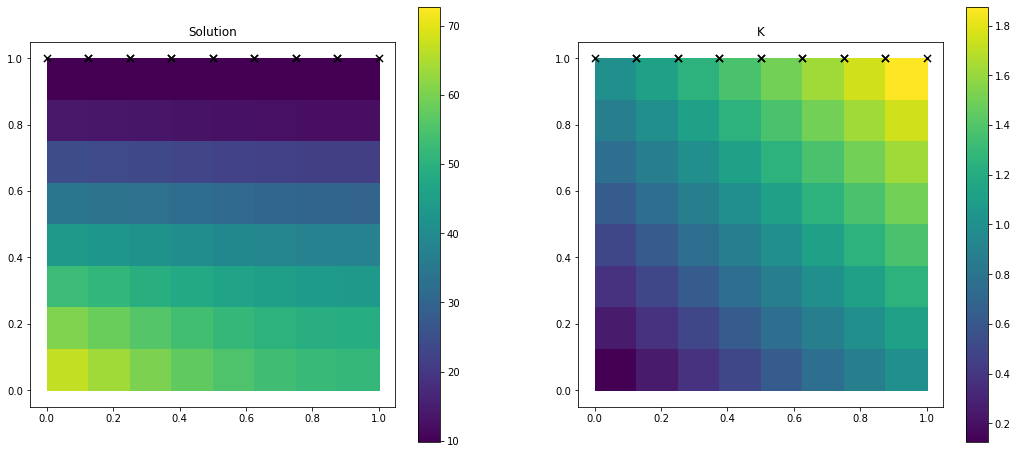

In [17]:
plot_solution(geometry, discretization, unknowns)

## Analyizing the convergence <div style="text-align: right"> **[6 points]** </div>
**Task** We want to compare the convergnce properties of our smoother with the v-cycle algorithm.
Answer the following questions:
- How many iterations are needed to get a residual lower than 1e-6?
- How many prolongations, restrictions, and smoother steps are needed for one/all multigrid cycles?
For the first one, write the code below, for the second one, write your answer in the following text field.

**Answer**: 

In [ ]:
# TODO Compute iterations for Jacobi

In [ ]:
# TODO Compute iterations for v-cycle